# Optimization of sartorious transfer paramters of viscous liquids guided by IPOPT optimization

## Summary

This notebook objective is to generate new suggestions of aspiration and dispense rates that will minimize the tansfer error while minimizing the time of transfer of a viscous liquid. 
The code is strucutred as follows:
1.  Fisrt section is for importing the relevant packages to perform BO, inclduing Pytorch and BOtorch
2.  Second section includes the definition of the BO_LiqTransfer class that includes the method optimized_suggestions() that generates BO optimized aspiration and dispense rate values for a particular data set.
3. Third section includes the code to initialize the automated platform.
4. Fourth section includes the code to run experiments using M1 robotic arm attached with electronic pipette, automated mass balance and IPOPT optimization of a viscous liquid. The steps for the optimziation are:
    i. Initilize a BO_LiTransfer objecet and load initilization data using data_from_csv() method

    ii. Run optimized_suggestions() method

    iii. Run liquid transfer gravimetric experiment using the best suggestion for aspiration and dispense rates

    iv. Update latest %error obtained from the transfer using suggested aspiration and dispense rates.
    
    v. Iterate through steps ii-iV

## 1. Imports

In [1]:
#%% General Imports
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

#sklearn imports
import sklearn.linear_model as linear_model

#pyomo
from pyomo.environ import *

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
REPO = 'viscosity_liquid_transfer_Pablo'
parent_path = os.getcwd().split(REPO)[0]

## 2. IPOPT_LiqTransfer class

In [3]:
class IPOPT_LiqTransfer:

    def __init__(self, liquid_name):
        self.liquid_name = liquid_name
        self._data = None
        self.features = ['aspiration_rate','dispense_rate']
        self.objectives = ['%error']
        self.bmax = 1.25
        self.bmin = 0.1
        self._latest_suggestion = None
        self._latest_volume = None
    
    def set_data(self,df):
        df['time_asp_1000'] = 1000/df['aspiration_rate'] + 1000/df['dispense_rate'] + df['delay_aspirate'] + df['delay_dispense']
        self._data = df

    
    def data_from_csv(self,file_name):
        data = pd.read_csv(file_name)
        data = data.loc[:,['liquid','pipette','volume','aspiration_rate','dispense_rate','blow_out','delay_aspirate','delay_dispense','delay_blow_out','%error']]
        self.set_data(data)

    def update_data(self,error):
        updated_data = pd.concat([self._data,self._data.iloc[[-1]]],ignore_index=True)
        updated_data.loc[updated_data.last_valid_index(),'volume'] = self._latest_volume
        updated_data.loc[updated_data.last_valid_index(),'aspiration_rate']  = self._latest_suggestion['aspiration_rate'][0]
        updated_data.loc[updated_data.last_valid_index(),'dispense_rate']  = self._latest_suggestion['dispense_rate'][0]
        updated_data.loc[updated_data.last_valid_index(),'%error'] = error
        self.set_data(updated_data)
        return self._data
                                
    def xy_split(self,volume=1000):
        df_train = self._data.where(self._data['volume']==volume).dropna(how='all').copy()
        x_train = df_train[self.features]
        y_train = df_train[self.objectives]
        return x_train,y_train

    def set_bounds(self, x_train):
        return x_train.iloc[0,0]*self.bmin, x_train.iloc[0,0]*self.bmax

    def fit_lin(self,volume=1000):
        lin_model = linear_model.LinearRegression()
        x_train,y_train = self.xy_split(volume=volume)
        
        min,max = self.set_bounds(x_train)

        lin_model.fit(x_train,y_train)


        m1,m2 = lin_model.coef_.tolist()[0]
        b= lin_model.intercept_.tolist()[0]

        return m1,m2,b,min,max
    

    
    

    
    def optimized_suggestions(self,volume= 1000):
        self._latest_volume = volume        
        
        model = ConcreteModel()
        m1,m2,b,min,max = self.fit_lin(volume=volume)

        def obj_time_for_1000(m):
    
            return 1000/m.x1 + 1000/m.x2 + 10
        # # Define decision variables

        model.x1 = Var(initialize= (min+max)/2, bounds = (min,max))
        model.x2 = Var(initialize= (min+max)/2, bounds = (min,max))

        model.obj = Objective(rule= obj_time_for_1000, sense=minimize)
        
        # Define constraints
        model.constraints = ConstraintList()
        model.constraints.add(expr= m1 * model.x1 + m2 * model.x2 + b <= 2.5)
        model.constraints.add(expr= m1 * model.x1 + m2 * model.x2 + b >= -2.5)
        model.constraints.add(expr= model.obj >= 10)

        solver = SolverFactory('ipopt')
        solver.solve(model)
        
        self._latest_suggestion = pd.DataFrame({'aspiration_rate':model.x1.value,'dispense_rate':model.x2.value}, index=[0])
        
        return self._latest_suggestion
        

        

## 3. Initialisation of automated platform

In [4]:
#Import relevant python packages
import pandas as pd
import time
from matplotlib import pyplot as plt
from pathlib import Path
import sys
REPOS = 'GitHub'
ROOT = str(Path().absolute()).split(REPOS)[0]
sys.path.append(f'{ROOT}{REPOS}')

from polylectric.configs.SynthesisB1 import SETUP, LAYOUT_FILE

from controllably import load_deck      # optional
load_deck(SETUP.setup, LAYOUT_FILE)     # optional

platform = SETUP
platform.mover.verbose = False

Import: OK <controllably.misc.decorators>
Import: OK <controllably.misc.helper>
Import: OK <controllably.misc.factory>
Import: OK <controllably.misc.layout>
Import: OK <controllably.misc.logger>
Import: OK <controllably.misc.misc_utils>


Import: OK <controllably.Compound.compound_utils>
Import: OK <controllably.Compound.LiquidMover.liquidmover_utils>


Import: OK <controllably.Move.move_utils>
Import: OK <controllably.Move.Jointed.jointed_utils>
Import: OK <controllably.Move.Jointed.Dobot.dobot_utils>
Import: OK <controllably.Move.Jointed.Dobot.m1pro_utils>
Import: OK <controllably.Move.Jointed.Dobot.mg400_utils>
ClearError()
receive: ClearError()
EnableRobot()
receive: EnableRobot()
User(0)
receive: User(0)
Tool(0)
receive: Tool(0)
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
Infeasible coordinates! (0.0, 0.0, 200.0)
Infeasible coordinates! (300.0, 1.1368683772161603e-13, 0.0)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 3.000s (1.000x

In [5]:
#Initialization of variables for platfomr objects
pipette= platform.setup
deck = platform.setup.deck
balance = platform.balance
balance_deck = deck.slots['1']
source = deck.slots['2']
tip_rack = deck.slots['3']
bin = deck.slots['4']
pipette.mover.setSpeed(50)
print(balance_deck)
print(source)
print(tip_rack)
print(bin)

SpeedFactor(50)
receive: SpeedFactor(50)
Mass_balance_plastic_jar 1 Well Plate 15000 uL at Slot 1
Polyelectric 6 Well Plate 15000 ÂµL at Slot 2
Eppendorf Motion 96 Tip Rack 1000 ÂµL at Slot 3
Polyetric_bin at Slot 4


In [6]:
#Check if balance is connected
balance.zero()
balance.toggleRecord(True)
time.sleep(5)
print(balance.buffer_df.iloc[-1])
balance.toggleRecord(False)

Listening...
Zeroing... (5s)
Stop listening...
Zeroing complete.
Listening...
Time        2023-06-06 14:35:29.135691
Value                           213950
Factor                        6.862879
Baseline                 213928.819512
Mass                          3.086239
Name: 24, dtype: object
Stop listening...


In [7]:
#Stablish initial height of liquid on the source vial
pipette_name = 'rLine1000'
liquid_level = 10.5

## 4. Guided IPOPT optimization
i.   Create IPOPT_LiqTransfer object and load data set.

Please set liquid name and volume to transfer according to the experiment.

In [8]:
# Change according to experiment
std = "505"
liquid_name = 'Viscosity_std_' + std 
density = 0.8683

# Do not change
liq = IPOPT_LiqTransfer(liquid_name)
liq.data_from_csv(parent_path+REPO+'\Sartorious_experiments\Initialisation_Data\Initialisation_' + std +'.csv')
liq._data

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,%error,time_asp_1000
0,Viscosity_std_505,rLine1000,1000,68.119973,68.119973,False,10,10,0,-15.238000,49.359965
1,Viscosity_std_505,rLine1000,500,68.119973,68.119973,False,10,10,0,-13.596795,49.359965
2,Viscosity_std_505,rLine1000,300,68.119973,68.119973,False,10,10,0,-9.722568,49.359965
3,Viscosity_std_505,rLine1000,1000,85.149966,85.149966,False,10,10,0,-23.024491,43.487972
4,Viscosity_std_505,rLine1000,500,85.149966,85.149966,False,10,10,0,-9.774031,43.487972
5,Viscosity_std_505,rLine1000,300,85.149966,85.149966,False,10,10,0,-8.072414,43.487972
6,Viscosity_std_505,rLine1000,500,6.811997,85.149966,False,10,10,0,-1.135053,178.543810
7,Viscosity_std_505,rLine1000,300,6.811997,85.149966,False,10,10,0,-3.418419,178.543810
8,Viscosity_std_505,rLine1000,1000,6.811997,85.149966,False,10,10,0,-21.782680,178.543810
9,Viscosity_std_505,rLine1000,1000,85.149966,6.811997,False,10,10,0,-0.791037,178.543810


ii.   Run IPOPT_LiqTransfer.optimized_suggestions() method to obtain optimized aspiration and dispense rates.

In [265]:
volume = 300
liq.optimized_suggestions(volume)

,aspiration_rate,dispense_rate
0,25.345826,21.836809


In [266]:
liquids_dict = {
  liquid_name :{
        "rLine1000": {
            "aspiration_rate": liq._latest_suggestion['aspiration_rate'][0], 
            "dispense_rate": liq._latest_suggestion['dispense_rate'][0], 
            "blow_out" : False, 
            "delay_aspirate" : 10, 
            "delay_dispense" : 10, 
            "delay_blow_out" : 0, 
            },
    }

}

iii. Run liquid transfer using the best suggestion for aspiration and dispense rates in OT2 notebook.

In [267]:


#Check if new tip is required
pipette.mover.setSpeed(50)
pipette.mover.setHandedness(False)

if pipette.liquid.isTipOn()== False:
    pipette.attachTip()

#Transfer start
start = time.time()

#Aspirate step
pipette.mover.safeMoveTo(source.wells['A1'].from_bottom((0,0,liquid_level-5)))
pipette.liquid.aspirate(volume, speed=liquids_dict[liquid_name][pipette_name]['aspiration_rate'])
time.sleep(liquids_dict[liquid_name][pipette_name]['delay_aspirate'])

pipette.touchTip(source.wells['A1'])

#Dispense step
pipette.mover.safeMoveTo(balance_deck.wells['A1'].from_top((0,0,-5)))

balance.tare()
balance.clearCache()
balance.toggleRecord(True)
time.sleep(5)


pipette.liquid.dispense(volume, speed=liquids_dict[liquid_name][pipette_name]['dispense_rate'])

time.sleep(liquids_dict[liquid_name][pipette_name]['delay_dispense'])

#Blowout step
if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
    pipette.liquid.blowout(home=False)
    time.sleep(liquids_dict[liquid_name][pipette_name]['delay_blow_out'])

#Transfer termination
finish = time.time()
time_m = finish - start

pipette.mover.safeMoveTo(source.wells['A1'].top)
time.sleep(5)
balance.toggleRecord(False)
if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
    pipette.liquid.home()

#Do blowout
pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()
time.sleep(10)
pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()
time.sleep(10)
pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()

Tip capacitance: 247
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[ 206.84309407 -146.68214574  200.        ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[ 206.84309407 -146.68214574  200.        ], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,52.350746,10.000000,0.000000,0.000000)
Move time: 1.476s (1.000x)
[ 206.84309407 -146.68214574   52.35074581], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 300.0 uL...
Target: 300.0 uL at 25.345825891843333 uL/s...
Best parameters: SpeedParameters(preset=650, intervals=11, step_size=10, delay=1.0340663649445576)
SpeedParameters(preset=650, intervals=11, step_size=10, delay=1.0340663649445576)
Speed 4: 650 uL/s
Aspiration time: 11.840580799995223s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(206.843

'ok'

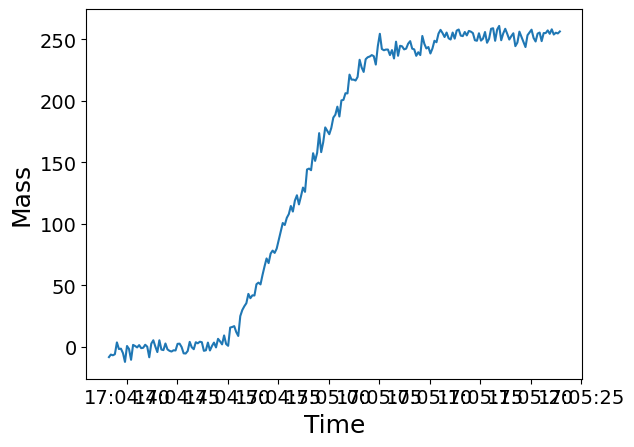

In [268]:
#Graph plotting 
fig,axs = plt.subplots()

axs.plot(balance.buffer_df['Time'],balance.buffer_df['Mass'])

axs.set_xlabel('Time')
axs.set_ylabel('Mass')

plt.show()

In [269]:
#Record trasnfer values 

m = (balance.buffer_df.iloc[-10:,-1].mean()-balance.buffer_df.iloc[:10,-1].mean())/1000
error = (m-density*volume/1000)/(density/1000*volume)*100

#New dataframe
df = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate','blow_out', 'delay_aspirate', 'delay_dispense','delay_blow_out', 'density', 'time', 'm', '%error', 'Transfer_Observation', 'Comment'])
df = df.astype({'liquid':str,'pipette':str,'blow_out':bool,'Transfer_Observation':str,'Comment':str})
df = pd.concat([df,pd.DataFrame(liquids_dict[liquid_name][pipette_name],index=[0])],ignore_index=True)
df.iloc[-1,-5] = time_m
df.iloc[-1,2] = volume
df.iloc[-1, 0] = liquid_name
df.iloc[-1, 1] = pipette_name
df.iloc[-1,-6] = density
df.iloc[-1, -4] = m
df.iloc[-1,-3]= error

In [270]:
#Update liquid level
# liquid_level = liquid_level - 1*volume/1000
liquid_level = liquid_level - 1.2*m/density

In [271]:
liquid_level 

7.481956370505331

In [272]:
#Observe error made
df.tail(20)

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,Transfer_Observation,Comment
0,Viscosity_std_505,rLine1000,300,25.345826,21.836809,False,10,10,0,0.8683,88.976156,0.259614,-0.336266,NaN,NaN


In [273]:
#Assign category of observation of transfer such as Incomplete Dispense, Incomplete Aspiration, 
#Incomplete Aspiration and Dispense, Complete Transfer. 
#Comment if any unexpected exprimental mistakes or changes were performed that have to be taken into account.
df.iloc[-1,-2]= 'Complete Transfer'
df.iloc[-1,-1]= 'Blowout before'

iv. Update latest %error obtained from the transfer using suggested aspiration and dispense rates.

In [274]:
liq.update_data(error)

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,%error,time_asp_1000
0,Viscosity_std_505,rLine1000,1000,68.119973,68.119973,False,10,10,0,-15.238000,49.359965
1,Viscosity_std_505,rLine1000,500,68.119973,68.119973,False,10,10,0,-13.596795,49.359965
2,Viscosity_std_505,rLine1000,300,68.119973,68.119973,False,10,10,0,-9.722568,49.359965
3,Viscosity_std_505,rLine1000,1000,85.149966,85.149966,False,10,10,0,-23.024491,43.487972
4,Viscosity_std_505,rLine1000,500,85.149966,85.149966,False,10,10,0,-9.774031,43.487972
5,Viscosity_std_505,rLine1000,300,85.149966,85.149966,False,10,10,0,-8.072414,43.487972
6,Viscosity_std_505,rLine1000,500,6.811997,85.149966,False,10,10,0,-1.135053,178.543810
7,Viscosity_std_505,rLine1000,300,6.811997,85.149966,False,10,10,0,-3.418419,178.543810
8,Viscosity_std_505,rLine1000,1000,6.811997,85.149966,False,10,10,0,-21.782680,178.543810
9,Viscosity_std_505,rLine1000,1000,85.149966,6.811997,False,10,10,0,-0.791037,178.543810


v. Iterate through last two code cells.

In [275]:
#save after each standard-experiment iteration
liq._data.to_csv(liquid_name+'_IPOPT_exp2.csv', index = False)

In [276]:
pipette.ejectTipAt(bin.wells['A1'].top)
pipette.mover.home()

Tip capacitance: 247
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
MovJ(320.000000,-240.000000,73.510000,10.000000,0.000000,0.000000)
Move time: 2.263s (0.500x)
[ 320.   -240.     73.51], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(320.000000,-240.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 6.325s (0.200x)
[ 320. -240.  200.], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(232.616399,194.960923,200.000000,10.000000,0.000000,0.000000)
Move time: 8.699s (0.500x)
[232.61639907 194.96092349 200.        ], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(232.616399,194.960923,114.400000,10.000000,0.000000,0.000000)
Move time: 4.280s (0.200x)
[232.61639907 194.96092349 114.4       ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(232.616399,194.960923,200.000000,10.000000,0.000000,0.000000)
Move time: 0.856s (1.000x)
[232.61639907 194.96092349 200.        ], [10  0  0]
SpeedFact

True

In [34]:
pipette.liquid.eject()

'ok'

In [246]:
pipette.mover.home()

SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[ 206.84309407 -146.68214574  200.        ], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 2.934s (0.500x)
[3.00000000e+02 1.13686838e-13 2.00000000e+02], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (1.000x)
[3.00000000e+02 1.13686838e-13 2.00000000e+02], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Homed


True

In [193]:
balance.connect()

Connection opened to COM5
Listening...
Zeroing... (5s)
Stop listening...
Zeroing complete.


In [39]:
pipette.mover.safeMoveTo(source.wells['A1'].top)

MovJ(198.894071,-3.942538,200.000000,10.000000,0.000000,0.000000)
Move time: 0.497s (1.000x)
[198.89407123  -3.94253829 200.        ], [10  0  0]
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 1.427s (1.000x)
[ 206.84309407 -146.68214574  200.        ], [10  0  0]
MovJ(206.843094,-146.682146,73.510000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[ 206.84309407 -146.68214574   73.51      ], [10  0  0]


True

In [92]:
pipette.liquid.dispense(1000)

Dispensing 1000.0 uL...
Dispense time: 2.4394632000039564s


'ok'